In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from implementations import *
from helpers import *

### Load data

In [2]:
DATA_FOLDER = 'data/'

In [41]:
try:
    with open(DATA_FOLDER + 'x_train.pickle', 'rb') as f:
        x_train = pickle.load(f)
    with open(DATA_FOLDER + 'x_test.pickle', 'rb') as f:
        x_test = pickle.load(f)
    with open(DATA_FOLDER + 'y_train.pickle', 'rb') as f:
        y_train = pickle.load(f)
    with open(DATA_FOLDER + 'test_ids.pickle', 'rb') as f:
        test_ids = pickle.load(f)
except:
    x_train, x_test, y_train, train_ids, test_ids = load_csv_data(DATA_FOLDER, sub_sample=False)

    names = np.genfromtxt(DATA_FOLDER + 'x_train.csv', delimiter=",", dtype=str, max_rows=1)
    names = np.delete(names, 0)
    names_map = {}
    for i in range(len(names)):
        names_map[names[i]] = i

    x_train[np.isnan(x_train)] = 0
    x_test[np.isnan(x_test)] = 0

    with open(DATA_FOLDER + 'x_train.pickle', 'wb') as f:
        pickle.dump(x_train, f)

    with open(DATA_FOLDER + 'x_test.pickle', 'wb') as f:
        pickle.dump(x_test, f)

    with open(DATA_FOLDER + 'y_train.pickle', 'wb') as f:
        pickle.dump(y_train, f)
        
    with open(DATA_FOLDER + 'test_ids.pickle', 'wb') as f:
        pickle.dump(test_ids, f)

In [35]:
# separate training and validation dataset
ratio = 0.8
np.seed = 42
n = x_train.shape[0]
train_indices = np.random.choice(n, int(ratio * n), replace=False)

x_tr, y_tr, x_val, y_val = x_train[train_indices, :], y_train[train_indices], np.delete(x_train, train_indices,
                                                                                        axis=0), np.delete(y_train,
                                                                                                           train_indices,
                                                                                                           axis=0)


### Sort of Cross-Validation on lambda and gamma

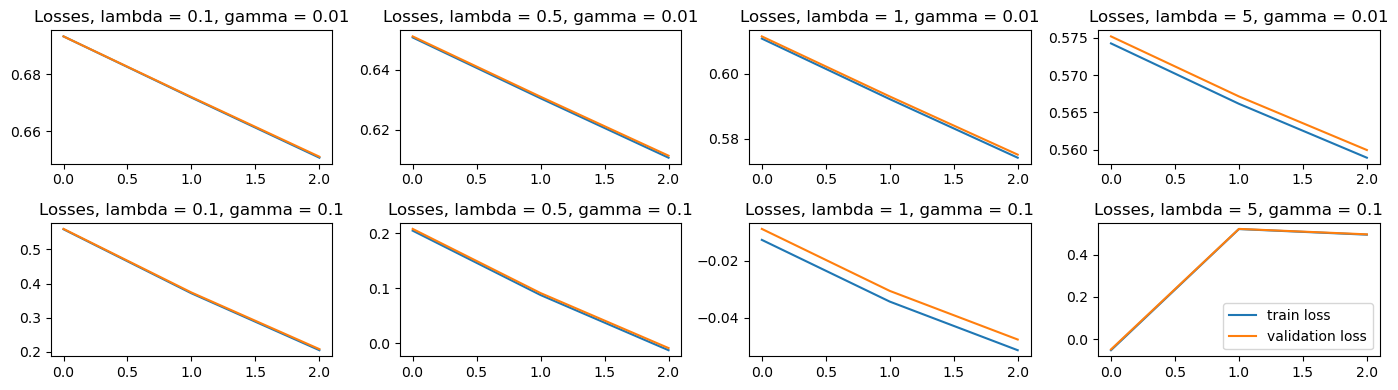

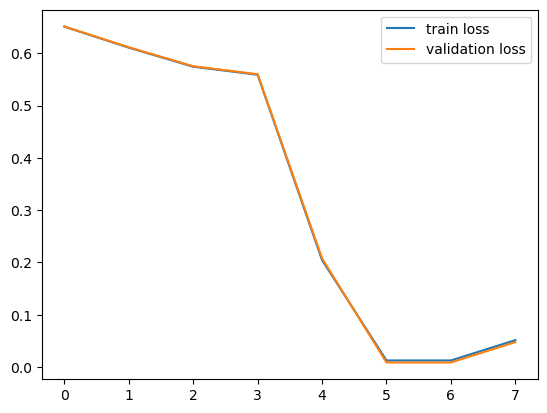

In [5]:
# Don't run this cell, it will take too much time

# lambda_ = 1
# gamma = 0.1

initial_w = np.zeros(x_tr.shape[1])
max_iters = 2

gammas = [0.01, 0.1]
lambdas = [0.1, 0.5, 1, 5]

losses_list = []
gen_losses_list = []

_, axes = plt.subplots(nrows=len(gammas), ncols=len(lambdas), figsize=(14, 4))

for i in range(len(gammas)):
    for j in range(len(lambdas)):
        w, losses, gen_losses = my_reg_logistic_regression(y_tr, x_tr, y_val, x_val, lambdas[j], initial_w, max_iters,
                                                           gammas[i])
        losses_list.append(np.min(np.abs(losses)))
        gen_losses_list.append(np.min(np.abs(gen_losses)))

        axes[i, j].plot(losses)
        axes[i, j].plot(gen_losses)
        axes[i, j].set_title(f"Losses, lambda = {lambdas[j]}, gamma = {gammas[i]}")

plt.legend(["train loss", "validation loss"])
plt.tight_layout()
plt.show()

plt.plot(losses_list)
plt.plot(gen_losses_list)
plt.legend(["train loss", "validation loss"])
plt.show()

# w, loss = logistic_regression(y_tr, x_tr, initial_w, max_iters, gamma)
# w, loss = reg_logistic_regression(y_train, x_train, lambda_, initial_w, max_iters, gamma)
# w, loss = my_reg_logistic_regression(y_tr, x_tr, y_val, x_val, lambda_, initial_w, max_iters, gamma)

# print(loss)

### Polynomial expansion

In [36]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree.

    Args:
        x: numpy array of shape (N,), N is the number of samples.
        degree: integer.

    Returns:
        poly: numpy array of shape (N,d+1)

    >>> build_poly(np.array([0.0, 1.5]), 2)
    array([[1.  , 0.  , 0.  ],
           [1.  , 1.5 , 2.25]])
    """
    feature_matrix = np.zeros((x.shape[0], degree * x.shape[1]))
    for i in range(1, degree + 1):
        feature_matrix[:, (i - 1) * x.shape[1]:i * x.shape[1]] = x ** i
    return feature_matrix

In [37]:
degree = 3

x_tr_exp = build_poly(x_tr, degree)
x_val_exp = build_poly(x_val, degree)

### Scaling and adding intercept

In [38]:
# Scaling each column
for i in range(x_tr_exp.shape[1]):
    x_tr_exp[:, i] = (x_tr_exp[:, i] - np.mean(x_tr_exp[:, i])) / np.std(x_tr_exp[:, i])
    x_val_exp[:, i] = (x_val_exp[:, i] - np.mean(x_val_exp[:, i])) / np.std(x_val_exp[:, i])
    
# Adding an intercept
x_tr_exp = np.c_[np.ones((x_tr_exp.shape[0], 1)), x_tr_exp]
x_val_exp = np.c_[np.ones((x_val_exp.shape[0], 1)), x_val_exp]

### Training

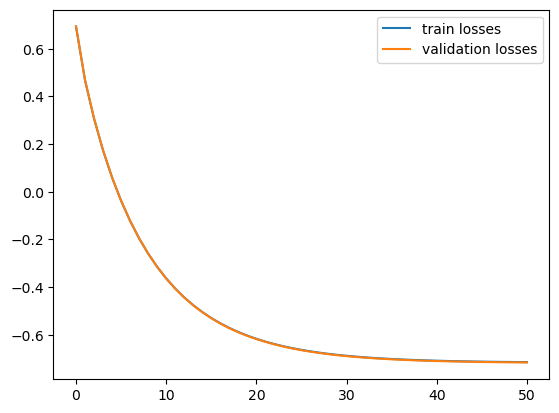

In [39]:
initial_w = np.zeros(x_tr_exp.shape[1])

max_iters = 50

gamma = 0.1
lambda_ = 0.5

w, losses, gen_losses = my_reg_logistic_regression(y_tr, x_tr_exp, y_val, x_val_exp, lambda_, initial_w, max_iters,
                                                   gamma)
plt.plot(losses)
plt.plot(gen_losses)
plt.legend(["train losses", "validation losses"])
plt.show()

### Testing

In [57]:
x_test_exp = build_poly(x_test, degree)
for i in range(x_test_exp.shape[1]):
    x_test_exp[:, i] = (x_test_exp[:, i] - np.mean(x_test_exp[:, i])) / np.std(x_test_exp[:, i])
x_test_exp = np.c_[np.ones((x_test_exp.shape[0], 1)), x_test_exp]

result = x_test_exp @ w
result = np.c_[test_ids, result]
result

array([[ 3.28135000e+05, -7.80637200e-01],
       [ 3.28136000e+05, -2.26782394e+00],
       [ 3.28137000e+05, -1.03641336e+00],
       ...,
       [ 4.37511000e+05, -7.44001439e-01],
       [ 4.37512000e+05,  2.35327385e-01],
       [ 4.37513000e+05, -7.66704268e-01]])

In [58]:
# Sigmoid to classify
result[:, 1] = 1 / (1 + np.exp(-result[:, 1]))
result[:, 1] = np.where(result[:, 1] > 0.5, 1, -1)

result

array([[ 3.28135e+05, -1.00000e+00],
       [ 3.28136e+05, -1.00000e+00],
       [ 3.28137e+05, -1.00000e+00],
       ...,
       [ 4.37511e+05, -1.00000e+00],
       [ 4.37512e+05,  1.00000e+00],
       [ 4.37513e+05, -1.00000e+00]])

In [59]:
with open(f'{DATA_FOLDER}result.csv', 'w') as f:
    f.write('Id,Prediction\n')
    for row in result:
        f.write(f'{int(row[0])},{int(row[1])}\n')